In [ ]:
 !pip install rasterio
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 84.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import rasterio
from rasterio.windows import from_bounds
from rasterio.transform import from_bounds as transform_from_bounds
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import PowerNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
raster_file = 'https://s3.opengeohub.org/gpw/arco/gpw_gpp_lue.model_m_30m_s_20220501_20220630_go_epsg.4326_v20240603.tif'

# Open the dataset
with rasterio.open(raster_file) as dataset:
    # Get the overviews
    overviews = dataset.overviews(1)
    # Print available overview levels
    print("Overview levels:", overviews)

    # Get geographic extent
    img_extent = [dataset.bounds.left, dataset.bounds.right, dataset.bounds.bottom, dataset.bounds.top]

    # Decimated reading
    oview_level = overviews[-2]
    overview_data = dataset.read(1, out_shape=(1, int(dataset.height // oview_level), int(dataset.width // oview_level)))

overview_data = np.ma.masked_where(overview_data == 255, overview_data)

Overview levels: [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]


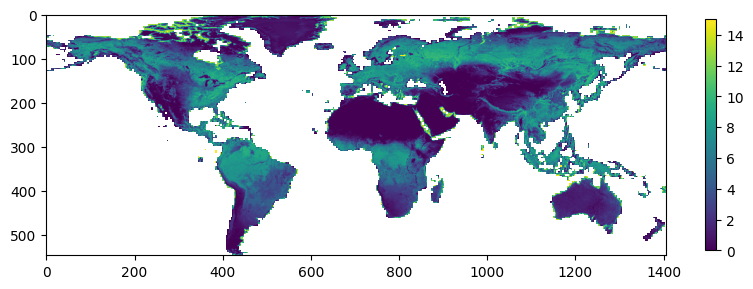

In [ ]:
plt.figure(figsize=(10,15))
plt.imshow(overview_data/10, vmin=0, vmax=15)
plt.colorbar(shrink=0.2)

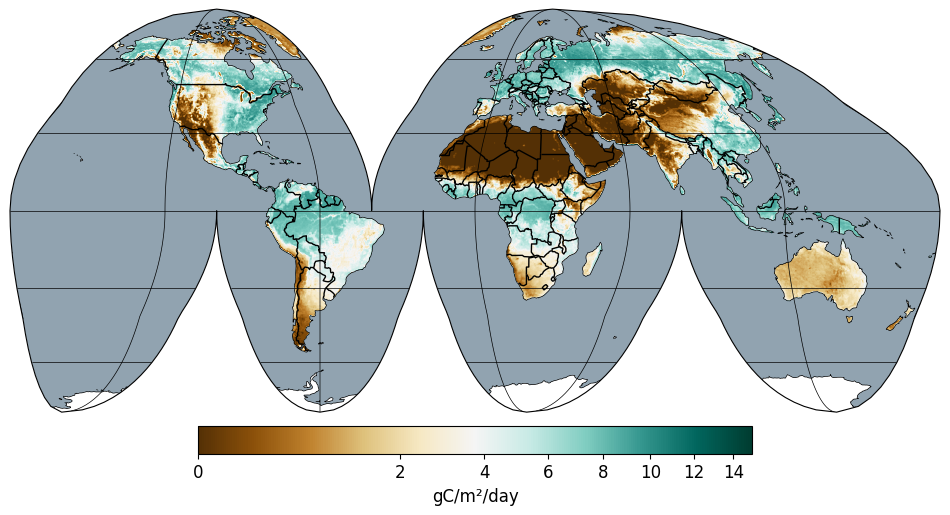

In [ ]:
fig = plt.figure(figsize=(12, 18))
projection = ccrs.InterruptedGoodeHomolosine()
ax = plt.axes(projection=projection)

# Define the CRS of the image data
img_crs = ccrs.PlateCarree()

# The majority of the GPP values falls between 0-100, so we squish the values after 100 a bit.
norm = PowerNorm(gamma=0.5, vmin=0, vmax=15)
im = ax.imshow(overview_data/10, extent=img_extent, transform=img_crs, cmap="BrBG", norm=norm)

# Add coastlines
ax.coastlines()
# Add borders
ax.add_feature(cfeature.BORDERS)

# Add ocean mask
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', scale='110m', edgecolor='none', facecolor="#91A3B0")
ax.add_feature(ocean)

# Final polishings ...
ax.set_global()
ax.gridlines(linestyle='-', linewidth=0.5, draw_labels=False, dms=True, zorder=15, color='k')
ax.set_aspect('equal')

# Colorbar for GPP values
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', fraction=0.02, pad=0.01)
cbar.set_label('gC/m²/day', fontsize=12)
cbar.ax.tick_params(labelsize=12)

plt.show()

# Calibration of GPP values w.r.t. LULC

In [ ]:
# Define the bounding box (in EPSG:4326 - lat/lon)
min_lon, max_lon = 16, 17  # Longitude bounds
min_lat, max_lat = 48, 49  # Latitude bounds

# Open the GeoTIFF file
with rasterio.open(raster_file) as src:
    # Get the bounding box
    window = from_bounds(min_lon, min_lat, max_lon, max_lat, transform=src.transform)

    # Read the data from the bounding box
    gpp_data = src.read(window=window)[0,:,:]

gpp_data = np.ma.masked_where(gpp_data == 255, gpp_data)
print("Shape of the window extracted:", gpp_data.shape)


Shape of the window extracted: (4000, 4000)


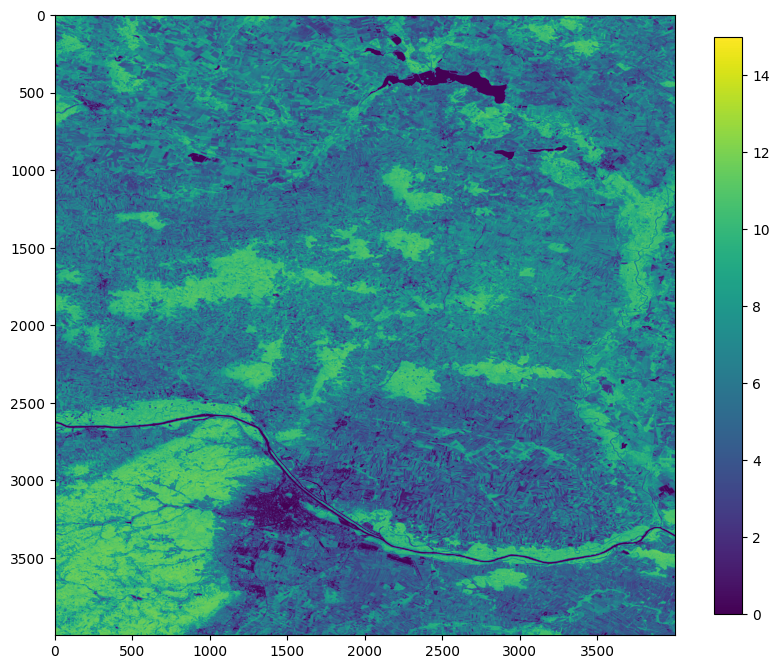

In [ ]:
plt.figure(figsize=(10,15))
plt.imshow(gpp_data/10, vmin=0, vmax=15)
plt.colorbar(shrink=0.5)

In [ ]:
landcover_file = "https://s3.openlandmap.org/arco/lc_mcd12q1v061.t1_c_500m_s_20210101_20211231_go_epsg.4326_v20230818.tif"

# Define the bounding box (in EPSG:4326 - lat/lon)
min_lon, max_lon = 16, 17  # Longitude bounds
min_lat, max_lat = 48, 49  # Latitude bounds


# Open the GeoTIFF file
with rasterio.open(landcover_file) as src:
    # Get the bounding box
    window = from_bounds(min_lon, min_lat, max_lon, max_lat, transform=src.transform)

    # Read the data from the bounding box
    landcover = src.read(window=window)[0,:,:]

landcover_interpolated = zoom(landcover, 500 / 30, order=0)  # NN interpolation
print("Original shape:", landcover.shape)
print("Resized shape:", landcover_interpolated.shape)

Original shape: (240, 240)
Resized shape: (4000, 4000)


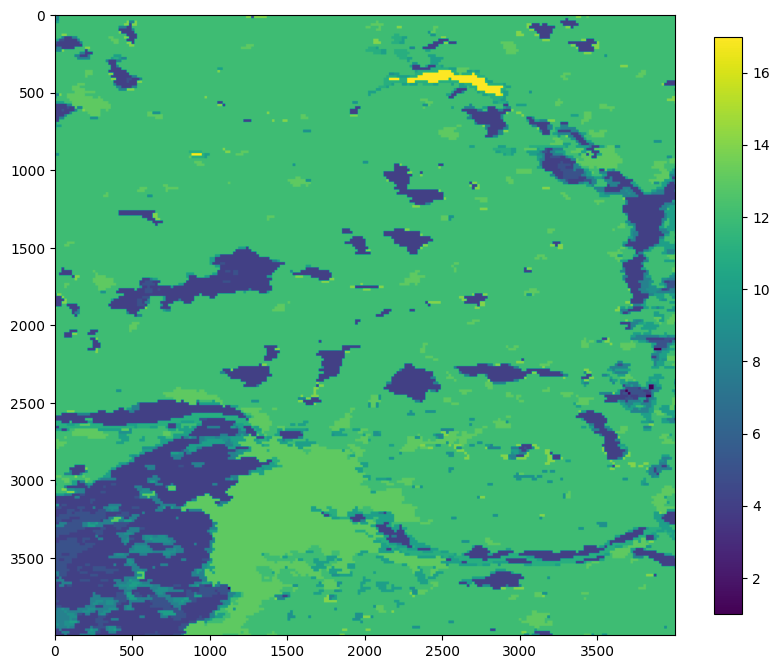

In [ ]:
plt.figure(figsize=(10,15))
plt.imshow(landcover_interpolated)
plt.colorbar(shrink=0.5)

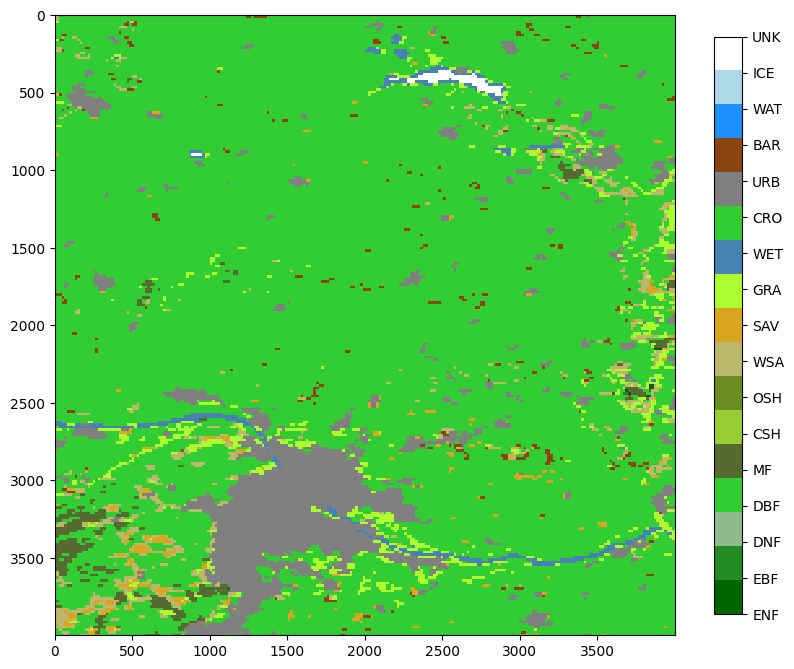

In [ ]:
class_colors = [
    '#006400',  # ENF (1) - Dark green for Evergreen Needleleaf Forests
    '#228B22',  # EBF (2) - Forest green for Evergreen Broadleaf Forests
    '#8FBC8F',  # DNF (3) - Light green for Deciduous Needleleaf Forests
    '#32CD32',  # DBF (4) - Lime green for Deciduous Broadleaf Forests
    '#556B2F',  # MF  (5) - Dark olive green for Mixed Forests
    '#9ACD32',  # CSH (6) - Yellow green for Closed Shrublands
    '#6B8E23',  # OSH (7) - Olive drab for Open Shrublands
    '#BDB76B',  # WSA (8) - Dark khaki for Woody Savannas
    '#DAA520',  # SAV (9) - Goldenrod for Savannas
    '#ADFF2F',  # GRA (10) - Green yellow for Grasslands
    '#4682B4',  # WET (11) - Steel blue for Wetlands
    '#32CD32',  # CRO (12) - Lime green for Croplands
    '#808080',  # URB (13) - Gray for Urban areas
    '#8B4513',  # BAR (14) - Saddle brown for Barren or sparsely vegetated
    '#1E90FF',  # WAT (15) - Dodger blue for Water bodies
    '#ADD8E6',  # ICE (16) - Light blue for Ice/Snow
    '#FFFFFF'   # UNK (17) - White for Unclassified
]

# Create a custom color map for landcover classes
landcover_cmap = ListedColormap(class_colors)

# Plot the landcover_interpolated data with the class-based colormap
plt.figure(figsize=(10, 15))
plt.imshow(landcover_interpolated, cmap=landcover_cmap, interpolation='none')

# Add colorbar
cbar = plt.colorbar(ticks=np.arange(1, 18), shrink=0.5)  # One tick per class
cbar.ax.set_yticklabels([lue_factors_mod17[i]['class'] for i in range(1, 18)])  # Class labels

plt.show()

In [ ]:
lue_factors_mod17 = {
    1: {"class": "ENF", "LUE_factor": 0.962},  # Evergreen Needleleaf Forests
    2: {"class": "EBF", "LUE_factor": 1.268},   # Evergreen Broadleaf Forests
    3: {"class": "DNF", "LUE_factor": 1.086},  # Deciduous Needleleaf Forests
    4: {"class": "DBF", "LUE_factor": 1.165},  # Deciduous Broadleaf Forests
    5: {"class": "MF",  "LUE_factor": 1.051},  # Mixed Forests
    6: {"class": "CSH", "LUE_factor": 1.281},  # Closed Shrublands
    7: {"class": "OSH", "LUE_factor": 0.841},  # Open Shrublands
    8: {"class": "WSA", "LUE_factor": 1.239},  # Woody Savannas
    9: {"class": "SAV", "LUE_factor": 1.206},  # Savannas
    10: {"class": "GRA", "LUE_factor": 0.860}, # Grasslands
    11: {"class": "WET", "LUE_factor": 0.000}, # Permanent Wetlands
    12: {"class": "CRO", "LUE_factor": 1.044}, # Croplands
    13: {"class": "URB", "LUE_factor": 0.0},  # Urban and Built-up Lands (not productive)
    14: {"class": "BAR", "LUE_factor": 0.0},  # Barren or Sparsely Vegetated (not productive)
    15: {"class": "WAT", "LUE_factor": 0.0},  # Water Bodies (not productive)
    16: {"class": "ICE", "LUE_factor": 0.0},  # Snow and Ice (not productive)
    17: {"class": "UNK", "LUE_factor": 0.0}   # Unclassified (not productive)
}


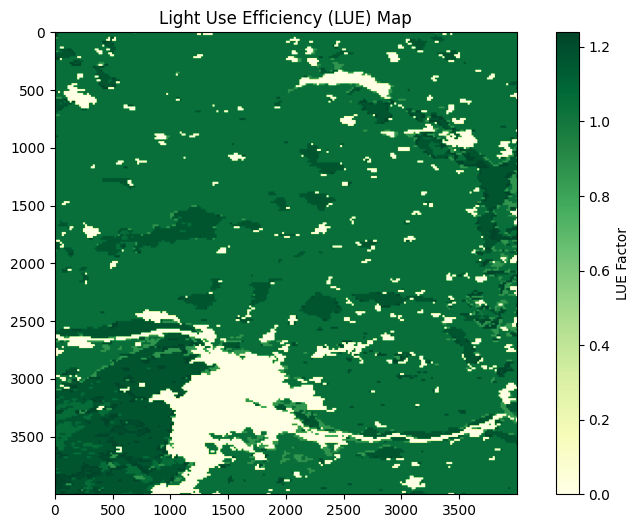

In [ ]:
lue_map = np.zeros_like(landcover_interpolated, dtype=float)

# Map the LUE factors to the corresponding landcover values
for class_value, lue_info in lue_factors_mod17.items():
    lue_map[landcover_interpolated == class_value] = lue_info['LUE_factor']

# Plot the resulting LUE map
plt.figure(figsize=(10, 6))
plt.imshow(lue_map, cmap='YlGn', vmin=0, vmax=np.max(lue_map))  # Use a color map for LUE
plt.colorbar(label='LUE Factor')
plt.title('Light Use Efficiency (LUE) Map')
plt.show()

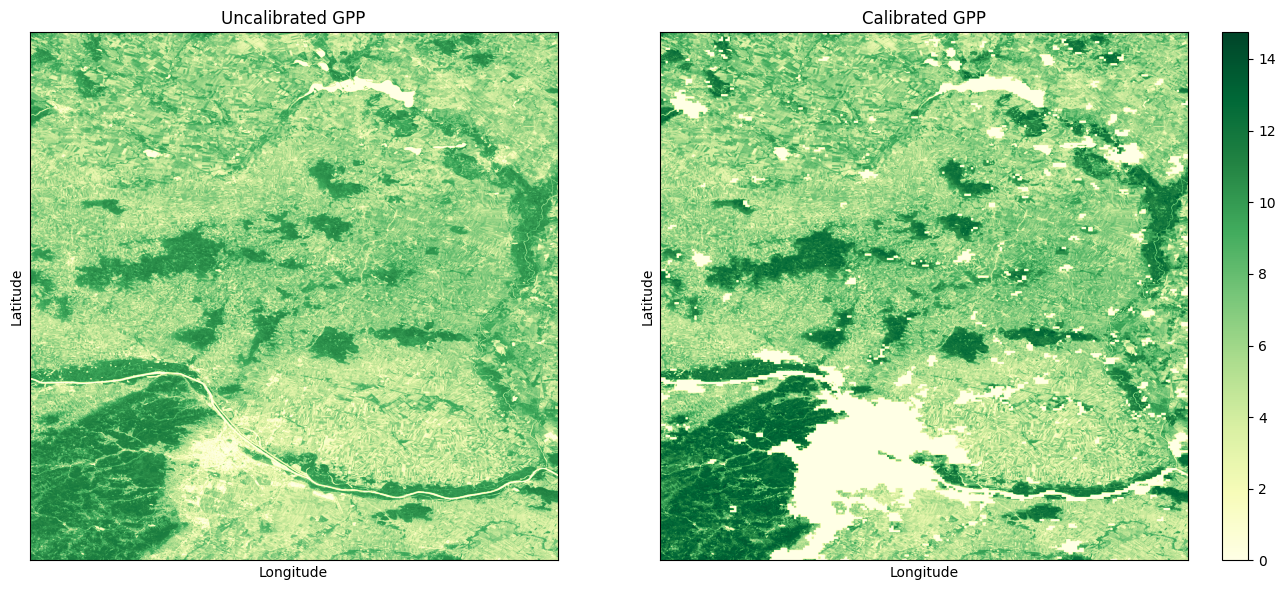

In [ ]:
# Calibrate the GPP values with the LUE map
calibrated_gpp = gpp_data * lue_map / 10

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot LUE map
axes[0].imshow(gpp_data/10, cmap='YlGn', vmin=0, vmax=np.max(calibrated_gpp))
axes[0].set_title('Uncalibrated GPP')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plot Resulting Map (LUE map * other_array)
im = axes[1].imshow(calibrated_gpp, cmap='YlGn', vmin=0, vmax=np.max(calibrated_gpp))
axes[1].set_title('Calibrated GPP')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

fig.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()